# RFM Customer Segmentation with K-Means Clustering

## Overview

This notebook performs customer segmentation using **RFM Analysis** (Recency, Frequency, Monetary) combined with **K-Means Clustering**.

### What is RFM Analysis?

RFM is a marketing analysis technique used to identify and segment customers based on their purchasing behavior:

- **Recency (R)**: How recently did the customer make a purchase?
- **Frequency (F)**: How often do they purchase?
- **Monetary (M)**: How much do they spend?

### Why K-Means Clustering?

K-Means clustering helps us automatically group customers with similar RFM characteristics, enabling:
- Targeted marketing campaigns
- Personalized customer experiences
- Resource optimization
- Churn prediction and prevention

### Data Architecture

This analysis connects to a **Dremio-powered Data Lakehouse** with Medallion Architecture:
- **Bronze**: Raw data ingestion
- **Silver**: Cleansed and validated data
- **Gold**: Business-level aggregates and analytics-ready datasets

## 1. Setup and Dependencies

In [9]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

# Data connection
from pyarrow import flight
import pyarrow as pa
import base64

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Date handling
from datetime import datetime, timedelta

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## 2. Connect to Dremio Data Lakehouse

We'll connect to Dremio using Apache Arrow Flight, which provides high-performance data transfer.

**Connection Details**:
- Host: dremio
- Port: 32010 (Arrow Flight)
- Authentication: Basic (username/password)

In [10]:
def connect_to_dremio(host='dremio', port=32010, username='dremio', password='dremio123'):
    """
    Establish connection to Dremio via Arrow Flight.
    
    Parameters:
    -----------
    host : str
        Dremio hostname
    port : int
        Arrow Flight port (default: 32010)
    username : str
        Dremio username
    password : str
        Dremio password
    
    Returns:
    --------
    tuple : (client, options)
        Arrow Flight client and authentication options
    """
    try:
        # Create flight client
        client = flight.connect(f"grpc://{host}:{port}")
        
        # Create basic auth header
        auth_string = f"{username}:{password}"
        auth_encoded = base64.b64encode(auth_string.encode()).decode()
        options = flight.FlightCallOptions(
            headers=[(b"authorization", f"Basic {auth_encoded}".encode())]
        )
        
        print(f"✓ Successfully connected to Dremio at {host}:{port}")
        return client, options
    
    except Exception as e:
        print(f"✗ Connection failed: {str(e)}")
        raise

# Establish connection
client, options = connect_to_dremio()

✓ Successfully connected to Dremio at dremio:32010


In [11]:
def query_dremio(client, options, sql_query):
    """
    Execute SQL query against Dremio and return results as pandas DataFrame.
    
    Parameters:
    -----------
    client : FlightClient
        Arrow Flight client connection
    options : FlightCallOptions
        Authentication options
    sql_query : str
        SQL query to execute
    
    Returns:
    --------
    pd.DataFrame
        Query results as pandas DataFrame
    """
    try:
        # Get flight info for the query
        flight_info = client.get_flight_info(
            flight.FlightDescriptor.for_command(sql_query),
            options
        )
        
        # Retrieve data from the first endpoint
        reader = client.do_get(flight_info.endpoints[0].ticket, options)
        
        # Convert to pandas DataFrame
        df = reader.read_pandas()
        
        print(f"✓ Query executed successfully. Retrieved {len(df):,} rows")
        return df
    
    except Exception as e:
        print(f"✗ Query failed: {str(e)}")
        raise

print("✓ Query function defined")

✓ Query function defined


## 3. Data Exploration

Let's explore the available datasets in our gold layer to understand customer behavior patterns.

In [12]:
# Load customer lifetime value data from gold layer
# Actual columns: customer_id, first_name, email, total_spent, total_transactions, average_transaction_value
sql_clv = """
SELECT 
    customer_id,
    first_name,
    total_spent,
    total_transactions
FROM catalog.gold.customer_lifetime_value
WHERE customer_id IS NOT NULL
    AND total_spent > 0
"""

df_clv = query_dremio(client, options, sql_clv)
print(f"\nCustomer Lifetime Value Dataset Shape: {df_clv.shape}")
df_clv.head()

✓ Query executed successfully. Retrieved 2,272 rows

Customer Lifetime Value Dataset Shape: (2272, 4)


,customer_id,first_name,total_spent,total_transactions
0,9,Abner,133861.39,2
1,2071,Giff,194121.92,2
2,1716,Eddy,108558.95,3
3,2189,Quinn,315473.46,5
4,208,Gwenny,259529.46,5


In [13]:
# Load sales data to get recency (last purchase date)
# Actual columns: sale_id, sale_date, sale_price, payment_method, customer_name, vehicle_model
sql_sales = """
SELECT 
    customer_name,
    sale_date,
    sale_price
FROM catalog.gold.enriched_sales
WHERE customer_name IS NOT NULL
    AND sale_price > 0
ORDER BY customer_name, sale_date
"""

df_sales = query_dremio(client, options, sql_sales)
print(f"\nSales Dataset Shape: {df_sales.shape}")
df_sales.head()

✓ Query executed successfully. Retrieved 5,800 rows

Sales Dataset Shape: (5800, 3)


,customer_name,sale_date,sale_price
0,Abbey,2023-12-16,51108.89
1,Abbi,2023-07-31,43524.39
2,Abbi,2023-12-06,54137.26
3,Abbie,2023-05-20,79669.76
4,Abbie,2023-05-31,52752.56


In [14]:
# Display basic statistics
print("=" * 80)
print("CUSTOMER LIFETIME VALUE - SUMMARY STATISTICS")
print("=" * 80)
print(df_clv.describe())

print("\n" + "=" * 80)
print("DATA QUALITY CHECK")
print("=" * 80)
print(f"Total Unique Customers (CLV): {df_clv['customer_id'].nunique():,}")
print(f"Total Unique Customers (Sales): {df_sales['customer_name'].nunique():,}")
print(f"Total Sales Records: {len(df_sales):,}")
print(f"Date Range: {df_sales['sale_date'].min()} to {df_sales['sale_date'].max()}")
print(f"\nMissing Values in CLV:\n{df_clv.isnull().sum()}")

CUSTOMER LIFETIME VALUE - SUMMARY STATISTICS
       total_spent  total_transactions
count      2272.00             2272.00
mean     165078.20                2.55
std       91796.22                1.35
min       30337.26                1.00
25%       91917.05                2.00
50%      151044.30                2.00
75%      220524.93                3.00
max      589048.28                8.00

DATA QUALITY CHECK
Total Unique Customers (CLV): 2,272
Total Unique Customers (Sales): 1,976
Total Sales Records: 5,800
Date Range: 2023-03-23 to 2024-03-22

Missing Values in CLV:
customer_id           0
first_name            0
total_spent           0
total_transactions    0
dtype: int64


## 4. RFM Feature Engineering

Now we'll calculate the three critical RFM metrics for each customer.

### Feature Definitions:

1. **Recency**: Days since the customer's last purchase (lower is better)
2. **Frequency**: Total number of purchases made by the customer (higher is better)
3. **Monetary**: Total amount spent by the customer (higher is better)

In [15]:
# Set analysis date (most recent date in sales data)
df_sales['sale_date'] = pd.to_datetime(df_sales['sale_date'])
analysis_date = df_sales['sale_date'].max()
print(f"Analysis Date: {analysis_date}")
print(f"This represents the 'current' date for calculating recency\n")

# Calculate last purchase date per customer from sales
recency_df = df_sales.groupby('customer_name').agg({
    'sale_date': 'max'
}).reset_index()
recency_df.columns = ['customer_name', 'last_purchase']
recency_df['recency'] = (analysis_date - recency_df['last_purchase']).dt.days

print(f"✓ Recency calculated for {len(recency_df):,} customers")
recency_df.head()

Analysis Date: 2024-03-22 00:00:00
This represents the 'current' date for calculating recency

✓ Recency calculated for 1,976 customers


,customer_name,last_purchase,recency
0,Abbey,2023-12-16,97
1,Abbi,2023-12-06,107
2,Abbie,2023-05-31,296
3,Abbye,2024-01-06,76
4,Abigail,2024-02-28,23


In [16]:
# Merge recency data with CLV data
# Join on customer_name (from sales) = first_name (from CLV)
rfm_df = df_clv.merge(
    recency_df[['customer_name', 'recency']], 
    left_on='first_name', 
    right_on='customer_name', 
    how='inner'
)

# Rename columns for clarity
rfm_df['frequency'] = rfm_df['total_transactions']
rfm_df['monetary'] = rfm_df['total_spent']

# Select only necessary columns
rfm_df = rfm_df[['customer_id', 'first_name', 'recency', 'frequency', 'monetary']]

# Remove any outliers or invalid data
rfm_df = rfm_df[
    (rfm_df['recency'] >= 0) & 
    (rfm_df['frequency'] > 0) & 
    (rfm_df['monetary'] > 0)
]

print(f"✓ RFM features calculated for {len(rfm_df):,} customers\n")
print("Sample of RFM data:")
rfm_df.head(10)

✓ RFM features calculated for 2,272 customers

Sample of RFM data:


,customer_id,first_name,recency,frequency,monetary
0,9,Abner,234,2,133861.39
1,2071,Giff,257,2,194121.92
2,1716,Eddy,15,3,108558.95
3,2189,Quinn,143,5,315473.46
4,208,Gwenny,27,5,259529.46
5,1209,Gwenny,27,1,76246.19
6,905,Gwenny,27,4,227278.07
7,556,Nealy,0,6,366468.07
8,1338,Nealy,0,5,328808.79
9,2443,Barby,143,7,511448.08


In [17]:
# Display RFM statistics
print("=" * 80)
print("RFM METRICS - SUMMARY STATISTICS")
print("=" * 80)
print(rfm_df[['recency', 'frequency', 'monetary']].describe())

# Calculate additional insights
print("\n" + "=" * 80)
print("RFM INSIGHTS")
print("=" * 80)
print(f"Average Recency: {rfm_df['recency'].mean():.1f} days")
print(f"Average Frequency: {rfm_df['frequency'].mean():.1f} orders")
print(f"Average Monetary: ${rfm_df['monetary'].mean():.2f}")
print(f"\nMedian Recency: {rfm_df['recency'].median():.1f} days")
print(f"Median Frequency: {rfm_df['frequency'].median():.1f} orders")
print(f"Median Monetary: ${rfm_df['monetary'].median():.2f}")

RFM METRICS - SUMMARY STATISTICS
       recency  frequency   monetary
count  2272.00    2272.00    2272.00
mean    104.02       2.55  165078.20
std      89.90       1.35   91796.22
min       0.00       1.00   30337.26
25%      33.00       2.00   91917.05
50%      75.00       2.00  151044.30
75%     157.00       3.00  220524.93
max     365.00       8.00  589048.28

RFM INSIGHTS
Average Recency: 104.0 days
Average Frequency: 2.6 orders
Average Monetary: $165078.20

Median Recency: 75.0 days
Median Frequency: 2.0 orders
Median Monetary: $151044.30


### RFM Distribution Visualization

Let's visualize the distribution of each RFM metric to understand our customer base.

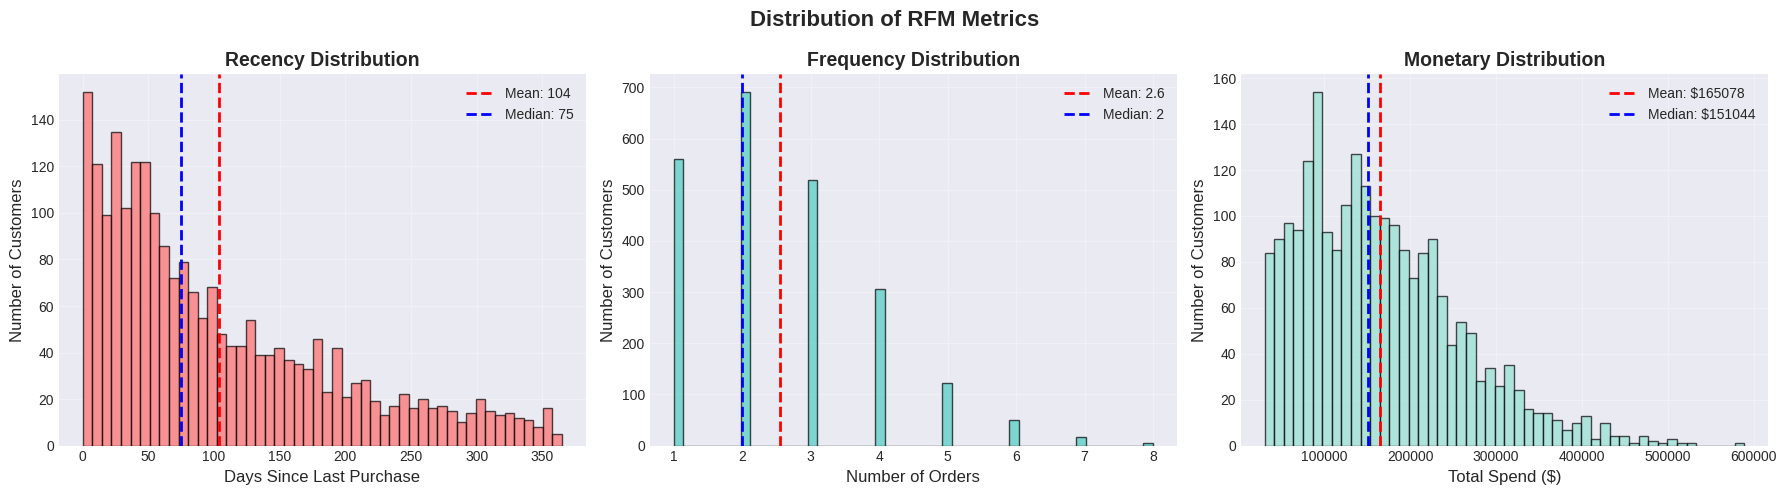


💡 Interpretation:
- Recency: Lower values indicate more recent customers (better engagement)
- Frequency: Higher values indicate loyal, repeat customers
- Monetary: Higher values indicate high-value customers


In [18]:
# Create distribution plots for RFM metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Distribution of RFM Metrics', fontsize=16, fontweight='bold')

# Recency distribution
axes[0].hist(rfm_df['recency'], bins=50, color='#FF6B6B', alpha=0.7, edgecolor='black')
axes[0].axvline(rfm_df['recency'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {rfm_df['recency'].mean():.0f}")
axes[0].axvline(rfm_df['recency'].median(), color='blue', linestyle='--', linewidth=2, label=f"Median: {rfm_df['recency'].median():.0f}")
axes[0].set_xlabel('Days Since Last Purchase', fontsize=12)
axes[0].set_ylabel('Number of Customers', fontsize=12)
axes[0].set_title('Recency Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Frequency distribution
axes[1].hist(rfm_df['frequency'], bins=50, color='#4ECDC4', alpha=0.7, edgecolor='black')
axes[1].axvline(rfm_df['frequency'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {rfm_df['frequency'].mean():.1f}")
axes[1].axvline(rfm_df['frequency'].median(), color='blue', linestyle='--', linewidth=2, label=f"Median: {rfm_df['frequency'].median():.0f}")
axes[1].set_xlabel('Number of Orders', fontsize=12)
axes[1].set_ylabel('Number of Customers', fontsize=12)
axes[1].set_title('Frequency Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Monetary distribution
axes[2].hist(rfm_df['monetary'], bins=50, color='#95E1D3', alpha=0.7, edgecolor='black')
axes[2].axvline(rfm_df['monetary'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: ${rfm_df['monetary'].mean():.0f}")
axes[2].axvline(rfm_df['monetary'].median(), color='blue', linestyle='--', linewidth=2, label=f"Median: ${rfm_df['monetary'].median():.0f}")
axes[2].set_xlabel('Total Spend ($)', fontsize=12)
axes[2].set_ylabel('Number of Customers', fontsize=12)
axes[2].set_title('Monetary Distribution', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("- Recency: Lower values indicate more recent customers (better engagement)")
print("- Frequency: Higher values indicate loyal, repeat customers")
print("- Monetary: Higher values indicate high-value customers")

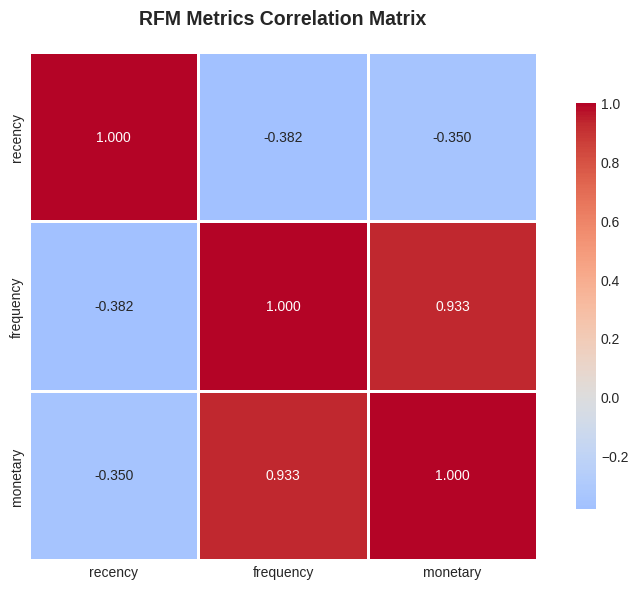


💡 Correlation Insights:
- Recency vs Frequency: -0.382
- Recency vs Monetary: -0.350
- Frequency vs Monetary: 0.933

Note: Negative correlation between Recency and other metrics is expected.
(Lower recency = more recent = generally higher frequency and monetary)


In [19]:
# Check for correlations between RFM metrics
correlation_matrix = rfm_df[['recency', 'frequency', 'monetary']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, fmt='.3f')
plt.title('RFM Metrics Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n💡 Correlation Insights:")
print(f"- Recency vs Frequency: {correlation_matrix.loc['recency', 'frequency']:.3f}")
print(f"- Recency vs Monetary: {correlation_matrix.loc['recency', 'monetary']:.3f}")
print(f"- Frequency vs Monetary: {correlation_matrix.loc['frequency', 'monetary']:.3f}")
print("\nNote: Negative correlation between Recency and other metrics is expected.")
print("(Lower recency = more recent = generally higher frequency and monetary)")

## 5. Feature Scaling

Before applying K-Means clustering, we need to **standardize** our features.

### Why Scale?

K-Means is distance-based, so features with larger scales can dominate the clustering:
- Recency: measured in days (0-1000+)
- Frequency: number of orders (1-100+)
- Monetary: dollar amounts (10-10,000+)

StandardScaler transforms each feature to have:
- Mean = 0
- Standard deviation = 1

This ensures all features contribute equally to the distance calculations.

In [20]:
# Prepare features for scaling
X = rfm_df[['recency', 'frequency', 'monetary']].values

# Initialize and fit the scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create DataFrame with scaled features for better visualization
rfm_scaled_df = pd.DataFrame(
    X_scaled, 
    columns=['recency_scaled', 'frequency_scaled', 'monetary_scaled'],
    index=rfm_df.index
)

print("✓ Features scaled using StandardScaler\n")
print("Original vs Scaled Statistics:")
print("=" * 80)

comparison = pd.DataFrame({
    'Original Mean': rfm_df[['recency', 'frequency', 'monetary']].mean(),
    'Original Std': rfm_df[['recency', 'frequency', 'monetary']].std(),
    'Scaled Mean': rfm_scaled_df.mean(),
    'Scaled Std': rfm_scaled_df.std()
})
print(comparison)

✓ Features scaled using StandardScaler

Original vs Scaled Statistics:
                  Original Mean  Original Std  Scaled Mean  Scaled Std
frequency                  2.55          1.35          NaN         NaN
frequency_scaled            NaN           NaN     1.16e-16         1.0
monetary              165078.20      91796.22          NaN         NaN
monetary_scaled             NaN           NaN     2.88e-16         1.0
recency                  104.02         89.90          NaN         NaN
recency_scaled              NaN           NaN     1.25e-17         1.0


## 6. Determining Optimal Number of Clusters

We'll use multiple methods to find the optimal k:

### 1. Elbow Method
- Plots Within-Cluster Sum of Squares (WCSS) vs number of clusters
- Look for the "elbow" point where adding more clusters provides diminishing returns

### 2. Silhouette Score
- Measures how similar an object is to its own cluster compared to other clusters
- Range: [-1, 1], higher is better
- Score > 0.5 indicates good clustering

### 3. Davies-Bouldin Index
- Measures average similarity between clusters
- Lower values indicate better clustering
- Minimum value of 0 (perfect separation)

In [21]:
# Calculate metrics for different numbers of clusters
k_range = range(2, 11)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []

print("Testing cluster sizes from 2 to 10...\n")

for k in k_range:
    # Fit K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_scaled)
    
    # Calculate metrics
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))
    
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, "
          f"Silhouette={silhouette_score(X_scaled, labels):.3f}, "
          f"Davies-Bouldin={davies_bouldin_score(X_scaled, labels):.3f}")

print("\n✓ Cluster evaluation complete")

Testing cluster sizes from 2 to 10...

k=2: Inertia=3594.76, Silhouette=0.410, Davies-Bouldin=0.926
k=3: Inertia=2329.63, Silhouette=0.392, Davies-Bouldin=0.865
k=4: Inertia=1680.42, Silhouette=0.390, Davies-Bouldin=0.856
k=5: Inertia=1383.11, Silhouette=0.389, Davies-Bouldin=0.866
k=6: Inertia=1157.87, Silhouette=0.371, Davies-Bouldin=0.851
k=7: Inertia=991.46, Silhouette=0.366, Davies-Bouldin=0.905
k=8: Inertia=856.32, Silhouette=0.371, Davies-Bouldin=0.860
k=9: Inertia=757.39, Silhouette=0.386, Davies-Bouldin=0.843
k=10: Inertia=690.17, Silhouette=0.381, Davies-Bouldin=0.900

✓ Cluster evaluation complete


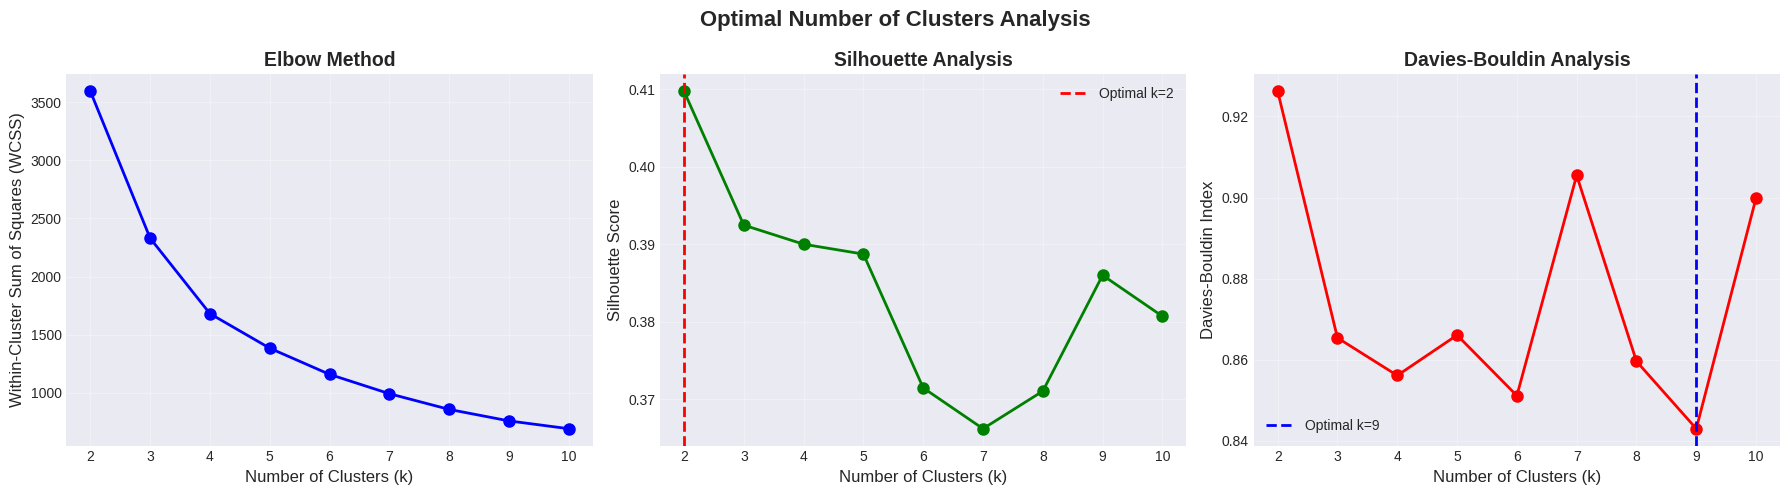


OPTIMAL CLUSTER RECOMMENDATIONS
Best k by Silhouette Score: 2 (score: 0.410)
Best k by Davies-Bouldin Index: 9 (score: 0.843)

💡 Recommended: Choose k=4 or k=5 for interpretable business segments


In [22]:
# Visualize clustering metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Optimal Number of Clusters Analysis', fontsize=16, fontweight='bold')

# Elbow Method
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_range)

# Silhouette Score
axes[1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
axes[1].axvline(optimal_k_silhouette, color='red', linestyle='--', linewidth=2, 
                label=f'Optimal k={optimal_k_silhouette}')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_range)

# Davies-Bouldin Index
axes[2].plot(k_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
optimal_k_db = k_range[np.argmin(davies_bouldin_scores)]
axes[2].axvline(optimal_k_db, color='blue', linestyle='--', linewidth=2, 
                label=f'Optimal k={optimal_k_db}')
axes[2].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[2].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[2].set_title('Davies-Bouldin Analysis', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(k_range)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("OPTIMAL CLUSTER RECOMMENDATIONS")
print("=" * 80)
print(f"Best k by Silhouette Score: {optimal_k_silhouette} (score: {max(silhouette_scores):.3f})")
print(f"Best k by Davies-Bouldin Index: {optimal_k_db} (score: {min(davies_bouldin_scores):.3f})")
print("\n💡 Recommended: Choose k=4 or k=5 for interpretable business segments")

## 7. K-Means Clustering with Optimal K

Based on the analysis above, we'll use **k=5** clusters to create distinct customer segments:

1. **Champions**: High value, recent, frequent buyers
2. **Loyal Customers**: Regular buyers with good frequency
3. **Potential Loyalists**: Recent customers with average frequency
4. **At Risk**: Previously valuable customers who haven't purchased recently
5. **Lost Customers**: Long inactive, low value customers

In [23]:
# Set optimal number of clusters
optimal_k = 5

# Fit final K-Means model
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=300)
rfm_df['cluster'] = kmeans_final.fit_predict(X_scaled)

# Add scaled features to main dataframe for visualization
rfm_df['recency_scaled'] = X_scaled[:, 0]
rfm_df['frequency_scaled'] = X_scaled[:, 1]
rfm_df['monetary_scaled'] = X_scaled[:, 2]

print(f"✓ K-Means clustering completed with k={optimal_k}\n")
print(f"Final Model Metrics:")
print(f"- Silhouette Score: {silhouette_score(X_scaled, rfm_df['cluster']):.3f}")
print(f"- Davies-Bouldin Index: {davies_bouldin_score(X_scaled, rfm_df['cluster']):.3f}")
print(f"- Inertia: {kmeans_final.inertia_:.2f}")

# Display cluster distribution
print("\n" + "=" * 80)
print("CLUSTER DISTRIBUTION")
print("=" * 80)
cluster_counts = rfm_df['cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(rfm_df)) * 100
    print(f"Cluster {cluster_id}: {count:,} customers ({percentage:.1f}%)")

✓ K-Means clustering completed with k=5

Final Model Metrics:
- Silhouette Score: 0.389
- Davies-Bouldin Index: 0.866
- Inertia: 1383.11

CLUSTER DISTRIBUTION
Cluster 0: 330 customers (14.5%)
Cluster 1: 627 customers (27.6%)
Cluster 2: 721 customers (31.7%)
Cluster 3: 242 customers (10.7%)
Cluster 4: 352 customers (15.5%)


### Cluster Profile Analysis

Let's examine the characteristics of each cluster to understand what makes each segment unique.

In [24]:
# Calculate cluster statistics
cluster_profile = rfm_df.groupby('cluster').agg({
    'recency': ['mean', 'median'],
    'frequency': ['mean', 'median'],
    'monetary': ['mean', 'median'],
    'customer_id': 'count'
}).round(2)

cluster_profile.columns = ['_'.join(col).strip() for col in cluster_profile.columns.values]
cluster_profile = cluster_profile.rename(columns={'customer_id_count': 'customer_count'})

print("=" * 100)
print("CLUSTER PROFILE ANALYSIS")
print("=" * 100)
print(cluster_profile)

# Add percentage of total customers
cluster_profile['percentage'] = (cluster_profile['customer_count'] / len(rfm_df) * 100).round(1)

print("\n" + "=" * 100)
print("CLUSTER SIZE DISTRIBUTION")
print("=" * 100)
print(cluster_profile[['customer_count', 'percentage']])

CLUSTER PROFILE ANALYSIS
         recency_mean  recency_median  frequency_mean  frequency_median  \
cluster                                                                   
0              265.07           268.5            1.18               1.0   
1               50.04            45.0            3.37               3.0   
2               58.60            52.0            1.61               2.0   
3               56.22            45.0            5.21               5.0   
4              175.10           170.5            2.47               2.0   

         monetary_mean  monetary_median  customer_count  
cluster                                                  
0             75645.27         75438.82             330  
1            215917.52        217838.45             627  
2            101732.71         98855.02             721  
3            347759.30        331007.69             242  
4            162521.03        159401.21             352  

CLUSTER SIZE DISTRIBUTION
         custome

In [25]:
# Assign meaningful names to clusters based on their RFM profiles
def assign_cluster_name(row):
    """
    Assign business-friendly names to clusters based on RFM characteristics.
    """
    cluster = row['cluster']
    cluster_stats = cluster_profile.loc[cluster]
    
    # Calculate relative scores (lower recency is better, higher frequency and monetary are better)
    recency_score = -row['recency_scaled']  # Invert so lower recency = higher score
    frequency_score = row['frequency_scaled']
    monetary_score = row['monetary_scaled']
    
    return cluster

# Create a mapping of cluster IDs to names based on their characteristics
# First, let's see the average characteristics of each cluster
cluster_summary = rfm_df.groupby('cluster')[['recency', 'frequency', 'monetary']].mean().round(2)

# Rank clusters by each metric (lower recency is better, higher freq/monetary is better)
cluster_summary['recency_rank'] = cluster_summary['recency'].rank()
cluster_summary['frequency_rank'] = cluster_summary['frequency'].rank(ascending=False)
cluster_summary['monetary_rank'] = cluster_summary['monetary'].rank(ascending=False)
cluster_summary['overall_rank'] = (cluster_summary['recency_rank'] + 
                                   cluster_summary['frequency_rank'] + 
                                   cluster_summary['monetary_rank'])

# Sort by overall rank to assign names
cluster_summary = cluster_summary.sort_values('overall_rank')

# Assign names based on characteristics
cluster_names = {}
for idx, (cluster_id, row) in enumerate(cluster_summary.iterrows()):
    if idx == 0:  # Best overall
        cluster_names[cluster_id] = 'Champions'
    elif idx == 1:  # Second best
        cluster_names[cluster_id] = 'Loyal Customers'
    elif idx == 2:  # Middle
        cluster_names[cluster_id] = 'Potential Loyalists'
    elif idx == 3:  # Fourth
        cluster_names[cluster_id] = 'At Risk'
    else:  # Worst
        cluster_names[cluster_id] = 'Lost Customers'

# Add cluster names to dataframe
rfm_df['cluster_name'] = rfm_df['cluster'].map(cluster_names)

print("✓ Cluster names assigned based on RFM characteristics\n")
print("=" * 100)
print("CLUSTER NAME MAPPING")
print("=" * 100)
for cluster_id, name in sorted(cluster_names.items()):
    stats = cluster_summary.loc[cluster_id]
    count = len(rfm_df[rfm_df['cluster'] == cluster_id])
    pct = (count / len(rfm_df)) * 100
    print(f"\nCluster {cluster_id}: {name}")
    print(f"  - Size: {count:,} customers ({pct:.1f}%)")
    print(f"  - Avg Recency: {cluster_summary.loc[cluster_id, 'recency']:.0f} days")
    print(f"  - Avg Frequency: {cluster_summary.loc[cluster_id, 'frequency']:.1f} orders")
    print(f"  - Avg Monetary: ${cluster_summary.loc[cluster_id, 'monetary']:.2f}")

✓ Cluster names assigned based on RFM characteristics

CLUSTER NAME MAPPING

Cluster 0: Lost Customers
  - Size: 330 customers (14.5%)
  - Avg Recency: 265 days
  - Avg Frequency: 1.2 orders
  - Avg Monetary: $75645.27

Cluster 1: Loyal Customers
  - Size: 627 customers (27.6%)
  - Avg Recency: 50 days
  - Avg Frequency: 3.4 orders
  - Avg Monetary: $215917.52

Cluster 2: At Risk
  - Size: 721 customers (31.7%)
  - Avg Recency: 59 days
  - Avg Frequency: 1.6 orders
  - Avg Monetary: $101732.71

Cluster 3: Champions
  - Size: 242 customers (10.7%)
  - Avg Recency: 56 days
  - Avg Frequency: 5.2 orders
  - Avg Monetary: $347759.30

Cluster 4: Potential Loyalists
  - Size: 352 customers (15.5%)
  - Avg Recency: 175 days
  - Avg Frequency: 2.5 orders
  - Avg Monetary: $162521.03


## 8. Visualization of Customer Segments

Now let's create compelling visualizations to understand our customer segments better.

### 8.1 Interactive 3D Scatter Plot

This visualization shows all three RFM dimensions simultaneously, allowing you to rotate and explore the clusters.

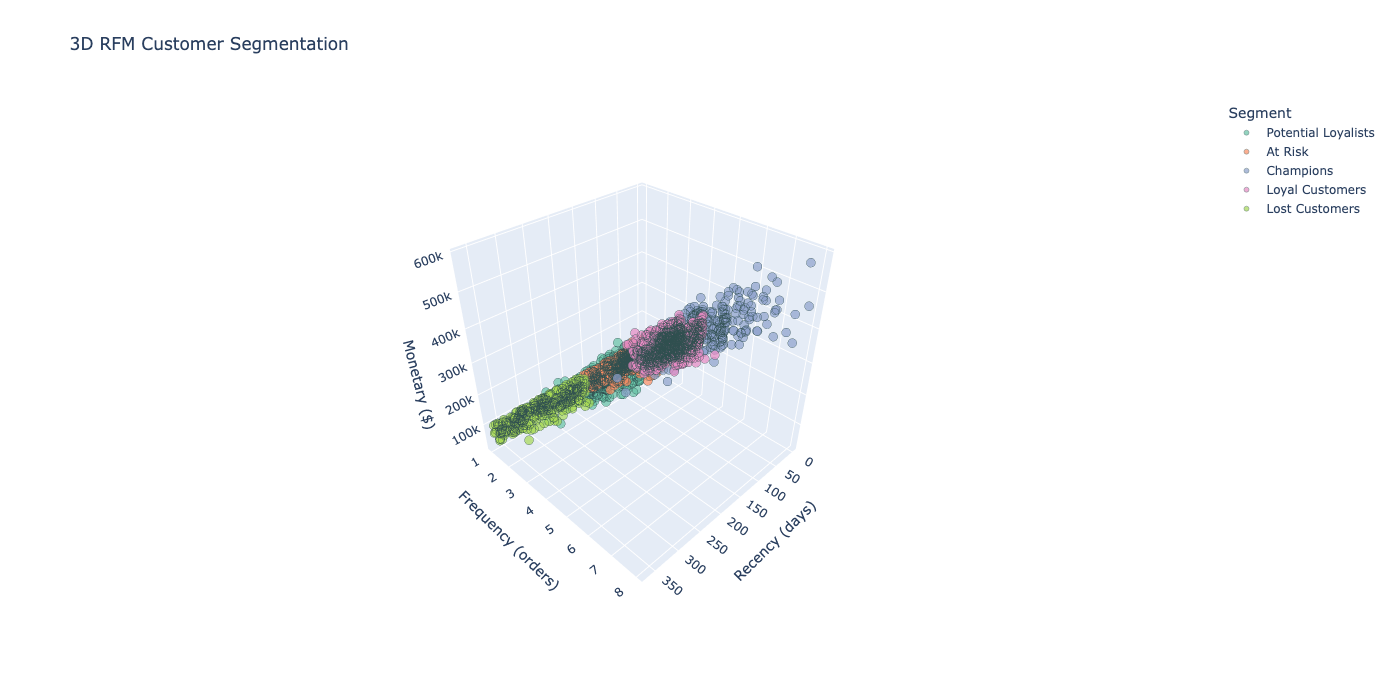


💡 Interaction Tips:
- Drag to rotate the plot
- Scroll to zoom in/out
- Click legend items to show/hide segments
- Hover over points to see customer details


In [26]:
# Create 3D scatter plot with Plotly
fig = px.scatter_3d(
    rfm_df,
    x='recency',
    y='frequency',
    z='monetary',
    color='cluster_name',
    hover_data=['customer_id', 'recency', 'frequency', 'monetary'],
    title='3D RFM Customer Segmentation',
    labels={
        'recency': 'Recency (days)',
        'frequency': 'Frequency (orders)',
        'monetary': 'Monetary ($)',
        'cluster_name': 'Segment'
    },
    color_discrete_sequence=px.colors.qualitative.Set2
)

fig.update_traces(
    marker=dict(size=5, opacity=0.7, line=dict(width=0.5, color='DarkSlateGray')),
    selector=dict(mode='markers')
)

fig.update_layout(
    scene=dict(
        xaxis_title='Recency (days)',
        yaxis_title='Frequency (orders)',
        zaxis_title='Monetary ($)',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
    ),
    height=700,
    font=dict(size=12)
)

fig.show()

print("\n💡 Interaction Tips:")
print("- Drag to rotate the plot")
print("- Scroll to zoom in/out")
print("- Click legend items to show/hide segments")
print("- Hover over points to see customer details")

### 8.2 Cluster Comparison Charts

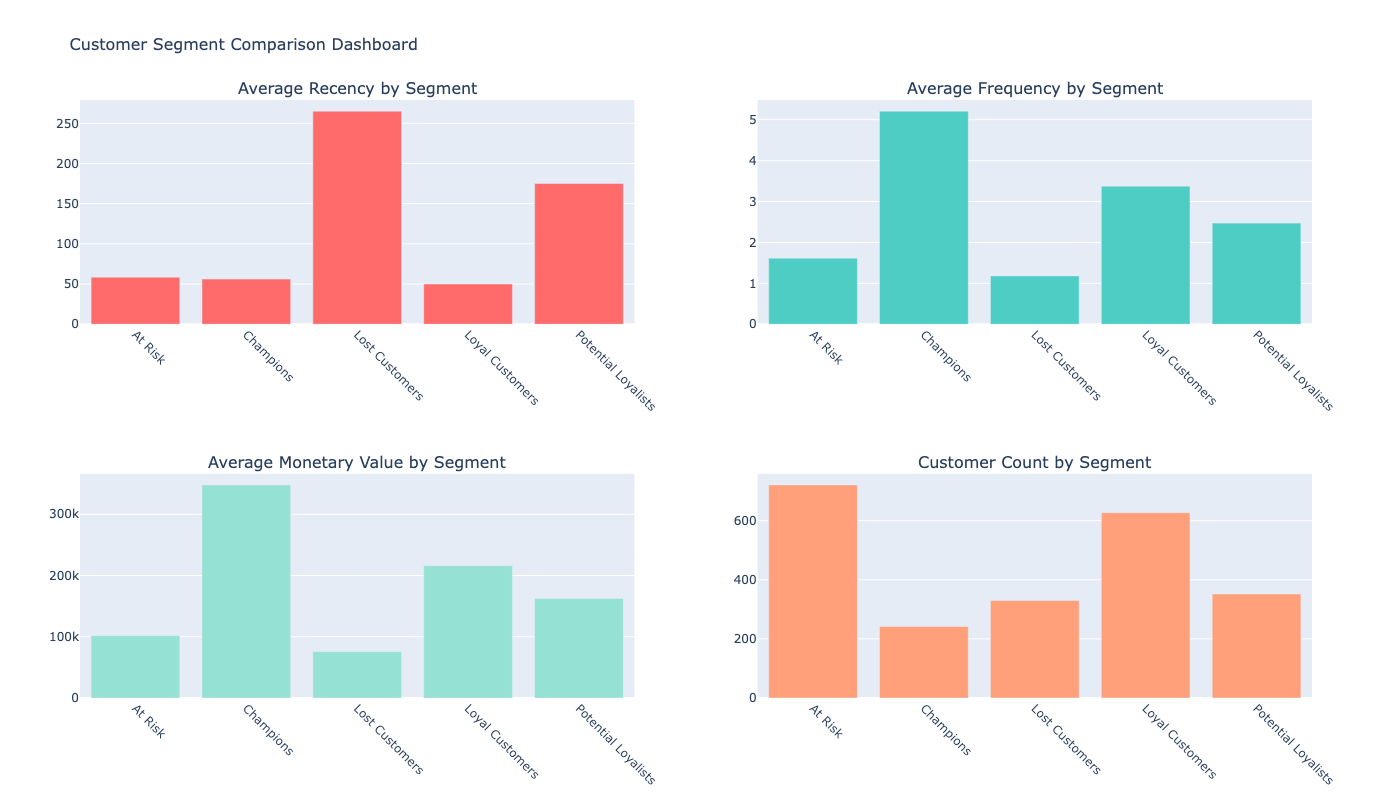

In [27]:
# Prepare data for cluster comparison
cluster_comparison = rfm_df.groupby('cluster_name').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'customer_id': 'count'
}).reset_index()

cluster_comparison.columns = ['Segment', 'Avg Recency', 'Avg Frequency', 'Avg Monetary', 'Customer Count']

# Create subplots
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Average Recency by Segment',
        'Average Frequency by Segment',
        'Average Monetary Value by Segment',
        'Customer Count by Segment'
    ),
    specs=[[{'type': 'bar'}, {'type': 'bar'}],
           [{'type': 'bar'}, {'type': 'bar'}]]
)

# Recency bar chart
fig.add_trace(
    go.Bar(x=cluster_comparison['Segment'], y=cluster_comparison['Avg Recency'],
           marker_color='#FF6B6B', name='Recency'),
    row=1, col=1
)

# Frequency bar chart
fig.add_trace(
    go.Bar(x=cluster_comparison['Segment'], y=cluster_comparison['Avg Frequency'],
           marker_color='#4ECDC4', name='Frequency'),
    row=1, col=2
)

# Monetary bar chart
fig.add_trace(
    go.Bar(x=cluster_comparison['Segment'], y=cluster_comparison['Avg Monetary'],
           marker_color='#95E1D3', name='Monetary'),
    row=2, col=1
)

# Customer count bar chart
fig.add_trace(
    go.Bar(x=cluster_comparison['Segment'], y=cluster_comparison['Customer Count'],
           marker_color='#FFA07A', name='Customer Count'),
    row=2, col=2
)

# Update layout
fig.update_xaxes(tickangle=45)
fig.update_layout(
    height=800,
    showlegend=False,
    title_text='Customer Segment Comparison Dashboard',
    title_font_size=16
)

fig.show()

### 8.3 Radar Chart for Segment Profiles

Radar charts are excellent for comparing multiple dimensions across segments.

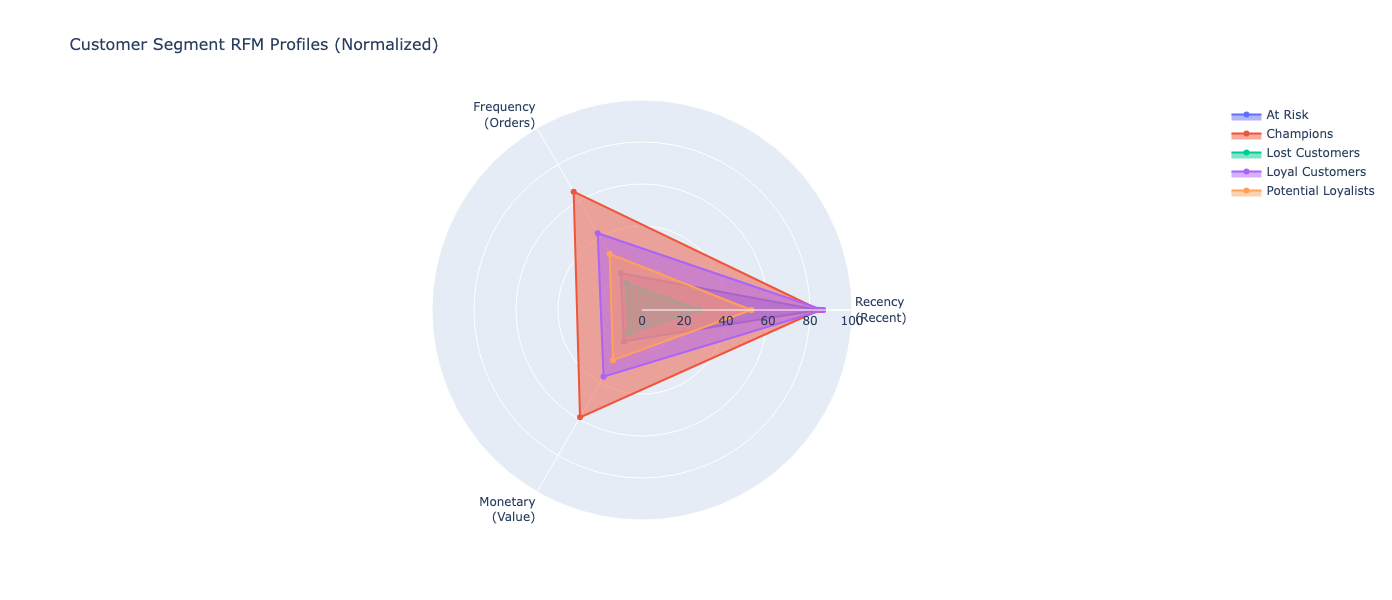


💡 Radar Chart Interpretation:
- Larger coverage = Better performance across all metrics
- Champions should have the largest area
- Lost Customers should have the smallest area


In [28]:
# Normalize RFM values for radar chart (0-100 scale)
# Note: For recency, we invert it so lower values (better) show as higher on the chart
rfm_normalized = rfm_df.copy()
rfm_normalized['recency_norm'] = 100 - (rfm_normalized['recency'] / rfm_normalized['recency'].max() * 100)
rfm_normalized['frequency_norm'] = rfm_normalized['frequency'] / rfm_normalized['frequency'].max() * 100
rfm_normalized['monetary_norm'] = rfm_normalized['monetary'] / rfm_normalized['monetary'].max() * 100

# Calculate average normalized values per cluster
radar_data = rfm_normalized.groupby('cluster_name')[['recency_norm', 'frequency_norm', 'monetary_norm']].mean()

# Create radar chart
fig = go.Figure()

categories = ['Recency<br>(Recent)', 'Frequency<br>(Orders)', 'Monetary<br>(Value)']

for segment in radar_data.index:
    fig.add_trace(go.Scatterpolar(
        r=radar_data.loc[segment].values.tolist() + [radar_data.loc[segment].values[0]],  # Close the loop
        theta=categories + [categories[0]],  # Close the loop
        fill='toself',
        name=segment,
        line=dict(width=2)
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 100]
        )
    ),
    showlegend=True,
    title='Customer Segment RFM Profiles (Normalized)',
    title_font_size=16,
    height=600
)

fig.show()

print("\n💡 Radar Chart Interpretation:")
print("- Larger coverage = Better performance across all metrics")
print("- Champions should have the largest area")
print("- Lost Customers should have the smallest area")

### 8.4 Box Plots for RFM Distribution by Segment

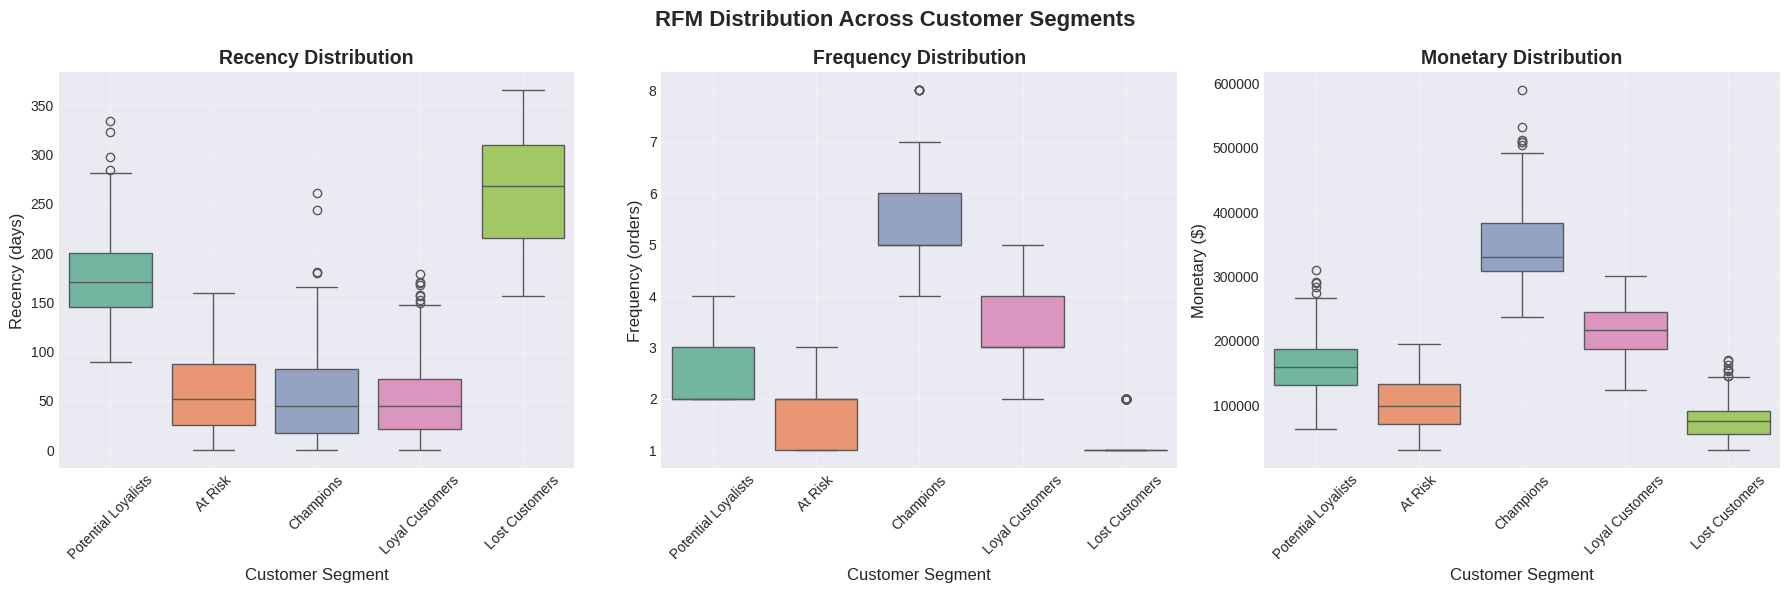


💡 Box Plot Interpretation:
- Box: Contains 50% of the data (25th to 75th percentile)
- Line in box: Median value
- Whiskers: Extend to 1.5 * IQR (Interquartile Range)
- Dots: Outliers beyond the whiskers


In [29]:
# Create box plots for each RFM metric
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('RFM Distribution Across Customer Segments', fontsize=16, fontweight='bold')

# Recency box plot
sns.boxplot(data=rfm_df, x='cluster_name', y='recency', ax=axes[0], palette='Set2')
axes[0].set_xlabel('Customer Segment', fontsize=12)
axes[0].set_ylabel('Recency (days)', fontsize=12)
axes[0].set_title('Recency Distribution', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Frequency box plot
sns.boxplot(data=rfm_df, x='cluster_name', y='frequency', ax=axes[1], palette='Set2')
axes[1].set_xlabel('Customer Segment', fontsize=12)
axes[1].set_ylabel('Frequency (orders)', fontsize=12)
axes[1].set_title('Frequency Distribution', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

# Monetary box plot
sns.boxplot(data=rfm_df, x='cluster_name', y='monetary', ax=axes[2], palette='Set2')
axes[2].set_xlabel('Customer Segment', fontsize=12)
axes[2].set_ylabel('Monetary ($)', fontsize=12)
axes[2].set_title('Monetary Distribution', fontsize=14, fontweight='bold')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Box Plot Interpretation:")
print("- Box: Contains 50% of the data (25th to 75th percentile)")
print("- Line in box: Median value")
print("- Whiskers: Extend to 1.5 * IQR (Interquartile Range)")
print("- Dots: Outliers beyond the whiskers")

## 9. Business Insights and Segment Descriptions

Let's translate our clusters into actionable business insights.

In [30]:
# Calculate detailed segment statistics
segment_stats = rfm_df.groupby('cluster_name').agg({
    'customer_id': 'count',
    'recency': ['mean', 'median'],
    'frequency': ['mean', 'median'],
    'monetary': ['mean', 'median', 'sum']
}).round(2)

segment_stats.columns = ['_'.join(col).strip() for col in segment_stats.columns.values]
segment_stats = segment_stats.rename(columns={'customer_id_count': 'customer_count'})

# Calculate revenue contribution
total_revenue = rfm_df['monetary'].sum()
segment_stats['revenue_contribution_%'] = (segment_stats['monetary_sum'] / total_revenue * 100).round(2)
segment_stats['avg_customer_value'] = segment_stats['monetary_mean']

# Sort by revenue contribution
segment_stats = segment_stats.sort_values('revenue_contribution_%', ascending=False)

print("=" * 120)
print("DETAILED CUSTOMER SEGMENT ANALYSIS")
print("=" * 120)
print(segment_stats)

# Create segment insights
print("\n\n" + "=" * 120)
print("SEGMENT-SPECIFIC INSIGHTS AND RECOMMENDATIONS")
print("=" * 120)

for segment_name in segment_stats.index:
    stats = segment_stats.loc[segment_name]
    segment_data = rfm_df[rfm_df['cluster_name'] == segment_name]
    
    print(f"\n{'='*100}")
    print(f"SEGMENT: {segment_name.upper()}")
    print(f"{'='*100}")
    
    print(f"\n📊 Size & Impact:")
    print(f"   - Customer Count: {stats['customer_count']:.0f} ({(stats['customer_count']/len(rfm_df)*100):.1f}% of total)")
    print(f"   - Revenue Contribution: ${stats['monetary_sum']:,.2f} ({stats['revenue_contribution_%']:.1f}% of total)")
    print(f"   - Average Customer Value: ${stats['avg_customer_value']:,.2f}")
    
    print(f"\n📈 RFM Profile:")
    print(f"   - Avg Recency: {stats['recency_mean']:.0f} days (Median: {stats['recency_median']:.0f} days)")
    print(f"   - Avg Frequency: {stats['frequency_mean']:.1f} orders (Median: {stats['frequency_median']:.0f} orders)")
    print(f"   - Avg Monetary: ${stats['monetary_mean']:,.2f} (Median: ${stats['monetary_median']:,.2f})")
    
    # Provide segment-specific recommendations
    print(f"\n💡 Characteristics:")
    if segment_name == 'Champions':
        print("   - Your best customers with high value, recent purchases, and high frequency")
        print("   - They buy often, spend the most, and engaged recently")
        print("   - Most profitable segment")
        print(f"\n🎯 Recommended Actions:")
        print("   1. VIP treatment with exclusive rewards and early access to new products")
        print("   2. Ask for reviews, testimonials, and referrals")
        print("   3. Engage them as brand ambassadors")
        print("   4. Provide personalized recommendations")
        print("   5. Monitor for any decrease in engagement")
        
    elif segment_name == 'Loyal Customers':
        print("   - Regular buyers who respond well to promotions")
        print("   - Consistent purchase behavior with good frequency")
        print("   - Solid revenue contributors")
        print(f"\n🎯 Recommended Actions:")
        print("   1. Upsell and cross-sell related products")
        print("   2. Loyalty program benefits and rewards")
        print("   3. Encourage them to become Champions through targeted offers")
        print("   4. Re-engagement campaigns to increase purchase frequency")
        print("   5. Personalized product recommendations")
        
    elif segment_name == 'Potential Loyalists':
        print("   - Recent customers with average frequency")
        print("   - Showing promise but need nurturing")
        print("   - Opportunity for growth")
        print(f"\n🎯 Recommended Actions:")
        print("   1. Onboarding campaigns to build loyalty")
        print("   2. Recommend popular/trending products")
        print("   3. Free shipping or discount incentives")
        print("   4. Educational content about product value")
        print("   5. Time-sensitive offers to increase frequency")
        
    elif segment_name == 'At Risk':
        print("   - Previously valuable customers losing engagement")
        print("   - Haven't purchased recently despite good history")
        print("   - Risk of churning to competitors")
        print(f"\n🎯 Recommended Actions:")
        print("   1. WIN-BACK campaigns with personalized offers")
        print("   2. Survey to understand why they stopped buying")
        print("   3. Limited-time discounts or special promotions")
        print("   4. Reminder of products they previously loved")
        print("   5. Address any service/product issues")
        
    elif segment_name == 'Lost Customers':
        print("   - Long inactive with low historical value")
        print("   - May have churned to competitors")
        print("   - Lowest priority but still worth targeting")
        print(f"\n🎯 Recommended Actions:")
        print("   1. Re-engagement campaigns with strong incentives")
        print("   2. Showcase new products or improvements since they left")
        print("   3. 'We miss you' campaigns with exclusive comeback offers")
        print("   4. Consider cost-benefit of reactivation efforts")
        print("   5. Learn from churn patterns to prevent future losses")

DETAILED CUSTOMER SEGMENT ANALYSIS
                     customer_count  recency_mean  recency_median  \
cluster_name                                                        
Loyal Customers                 627         50.04            45.0   
Champions                       242         56.22            45.0   
At Risk                         721         58.60            52.0   
Potential Loyalists             352        175.10           170.5   
Lost Customers                  330        265.07           268.5   

                     frequency_mean  frequency_median  monetary_mean  \
cluster_name                                                           
Loyal Customers                3.37               3.0      215917.52   
Champions                      5.21               5.0      347759.30   
At Risk                        1.61               2.0      101732.71   
Potential Loyalists            2.47               2.0      162521.03   
Lost Customers                 1.18              

### Revenue Impact Analysis

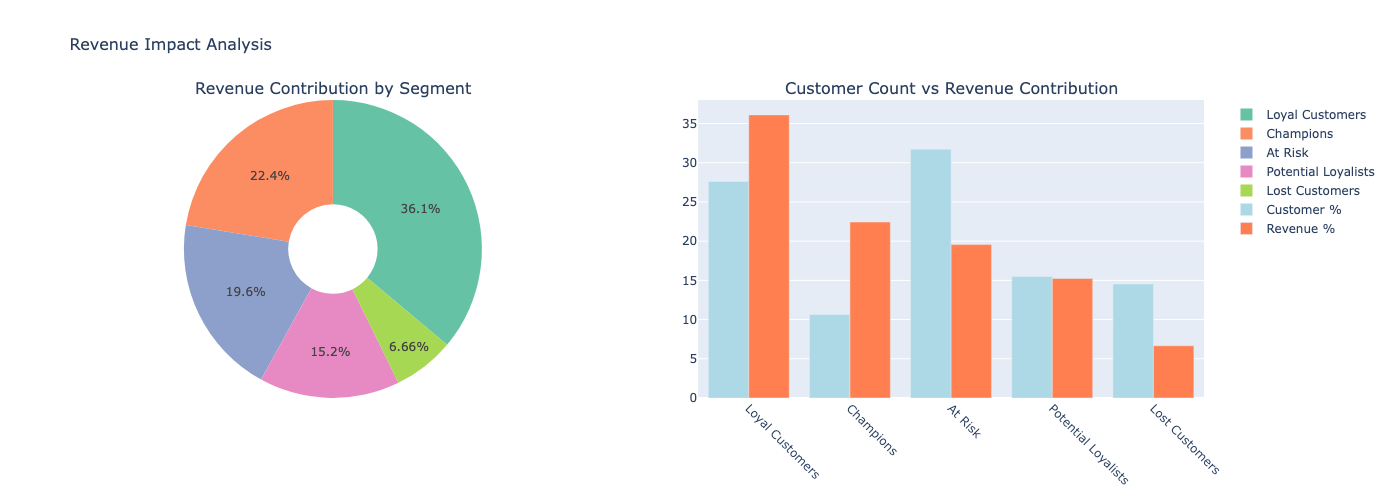


PARETO ANALYSIS (80/20 RULE)
Loyal Customers:
  - Cumulative Customers: 27.6%
  - Cumulative Revenue: 36.1%

Champions:
  - Cumulative Customers: 38.2%
  - Cumulative Revenue: 58.5%

At Risk:
  - Cumulative Customers: 70.0%
  - Cumulative Revenue: 78.1%

Potential Loyalists:
  - Cumulative Customers: 85.5%
  - Cumulative Revenue: 93.4%

Lost Customers:
  - Cumulative Customers: 100.0%
  - Cumulative Revenue: 100.0%

💡 Key Insight: 4 segment(s) contribute 80% of revenue:
   - Loyal Customers
   - Champions
   - At Risk
   - Potential Loyalists


In [31]:
# Create revenue contribution visualization
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'pie'}, {'type': 'bar'}]],
    subplot_titles=('Revenue Contribution by Segment', 'Customer Count vs Revenue Contribution')
)

# Pie chart for revenue contribution
fig.add_trace(
    go.Pie(
        labels=segment_stats.index,
        values=segment_stats['revenue_contribution_%'],
        hole=0.3,
        marker=dict(colors=px.colors.qualitative.Set2)
    ),
    row=1, col=1
)

# Bar chart comparing customer count vs revenue
customer_pct = (segment_stats['customer_count'] / len(rfm_df) * 100)
x_labels = segment_stats.index

fig.add_trace(
    go.Bar(
        name='Customer %',
        x=x_labels,
        y=customer_pct,
        marker_color='lightblue'
    ),
    row=1, col=2
)

fig.add_trace(
    go.Bar(
        name='Revenue %',
        x=x_labels,
        y=segment_stats['revenue_contribution_%'],
        marker_color='coral'
    ),
    row=1, col=2
)

fig.update_layout(
    height=500,
    showlegend=True,
    title_text='Revenue Impact Analysis',
    title_font_size=16
)

fig.update_xaxes(tickangle=45, row=1, col=2)

fig.show()

# Pareto analysis
print("\n" + "=" * 100)
print("PARETO ANALYSIS (80/20 RULE)")
print("=" * 100)
cumulative_revenue = segment_stats['revenue_contribution_%'].cumsum()
cumulative_customers = customer_pct.cumsum()

for idx, segment in enumerate(segment_stats.index):
    print(f"{segment}:")
    print(f"  - Cumulative Customers: {cumulative_customers.iloc[idx]:.1f}%")
    print(f"  - Cumulative Revenue: {cumulative_revenue.iloc[idx]:.1f}%")
    print()

# Find segments that contribute to 80% of revenue
segments_80_pct = segment_stats[cumulative_revenue <= 80].index.tolist()
if len(segments_80_pct) < len(segment_stats):
    segments_80_pct.append(segment_stats.index[len(segments_80_pct)])

print(f"💡 Key Insight: {len(segments_80_pct)} segment(s) contribute 80% of revenue:")
for seg in segments_80_pct:
    print(f"   - {seg}")

## 10. Export Results

Let's export our segmented customer data for use in marketing automation, CRM systems, or further analysis.

In [32]:
# Prepare final output dataframe
output_df = rfm_df[['customer_id', 'recency', 'frequency', 'monetary', 'cluster', 'cluster_name']].copy()

# Add segment priority (1 = highest priority)
priority_mapping = {
    'Champions': 1,
    'Loyal Customers': 2,
    'Potential Loyalists': 3,
    'At Risk': 4,
    'Lost Customers': 5
}
output_df['segment_priority'] = output_df['cluster_name'].map(priority_mapping)

# Sort by priority and customer value
output_df = output_df.sort_values(['segment_priority', 'monetary'], ascending=[True, False])

# Save to CSV (relative path for portability)
output_path = 'customer_segments.csv'
output_df.to_csv(output_path, index=False)

print(f"✓ Customer segmentation results exported to: {output_path}")
print(f"\nTotal customers segmented: {len(output_df):,}")
print(f"\nFirst 10 rows of exported data:")
output_df.head(10)

✓ Customer segmentation results exported to: customer_segments.csv

Total customers segmented: 2,272

First 10 rows of exported data:


,customer_id,recency,frequency,monetary,cluster,cluster_name,segment_priority
1646,479,28,8,589048.28,3,Champions,1
2124,1644,40,7,531668.15,3,Champions,1
9,2443,143,7,511448.08,3,Champions,1
457,224,24,7,509369.19,3,Champions,1
392,1822,3,6,509127.22,3,Champions,1
1909,61,51,7,504558.52,3,Champions,1
1700,769,57,7,491101.10,3,Champions,1
470,909,62,6,486073.33,3,Champions,1
1128,978,57,7,482594.10,3,Champions,1
1650,2073,52,6,475297.67,3,Champions,1


In [33]:
# Export segment summary statistics
summary_output = segment_stats.copy()
summary_output = summary_output.reset_index()
summary_output_path = 'segment_summary.csv'
summary_output.to_csv(summary_output_path, index=False)

print(f"✓ Segment summary statistics exported to: {summary_output_path}")
print(f"\nSegment Summary:")
print(summary_output)

✓ Segment summary statistics exported to: segment_summary.csv

Segment Summary:
          cluster_name  customer_count  recency_mean  recency_median  \
0      Loyal Customers             627         50.04            45.0   
1            Champions             242         56.22            45.0   
2              At Risk             721         58.60            52.0   
3  Potential Loyalists             352        175.10           170.5   
4       Lost Customers             330        265.07           268.5   

   frequency_mean  frequency_median  monetary_mean  monetary_median  \
0            3.37               3.0      215917.52        217838.45   
1            5.21               5.0      347759.30        331007.69   
2            1.61               2.0      101732.71         98855.02   
3            2.47               2.0      162521.03        159401.21   
4            1.18               1.0       75645.27         75438.82   

   monetary_sum  revenue_contribution_%  avg_customer_value 

## 11. Key Takeaways and Next Steps

### Summary

We successfully performed RFM customer segmentation using K-Means clustering, identifying distinct customer groups based on their purchasing behavior.

### What We Learned

1. **Data-Driven Segmentation**: Automated clustering identified natural customer groupings
2. **RFM Power**: Simple metrics (Recency, Frequency, Monetary) provide deep insights
3. **Revenue Concentration**: Likely 80% of revenue comes from 20% of customers
4. **Actionable Insights**: Each segment requires different marketing strategies

### Business Impact

- **Personalized Marketing**: Target each segment with appropriate campaigns
- **Resource Optimization**: Focus efforts on high-value segments
- **Churn Prevention**: Identify at-risk customers before they leave
- **Revenue Growth**: Convert Potential Loyalists into Champions

### Next Steps

1. **Integration**: Load segments into your CRM/Marketing automation platform
2. **A/B Testing**: Test different strategies for each segment
3. **Monitoring**: Track segment movement over time
4. **Advanced Analysis**:
   - Predict customer lifetime value (CLV)
   - Build churn prediction models
   - Analyze product affinity by segment
   - Time series analysis of segment evolution

### Recommended Refresh Frequency

- **Weekly**: Monitor key segments (Champions, At Risk)
- **Monthly**: Full re-segmentation and strategy adjustment
- **Quarterly**: Deep dive analysis and model refinement

In [34]:
# Generate final summary report
print("=" * 120)
print("FINAL EXECUTIVE SUMMARY")
print("=" * 120)
print(f"\nAnalysis Date: {analysis_date.strftime('%Y-%m-%d')}")
print(f"Total Customers Analyzed: {len(rfm_df):,}")
print(f"Total Revenue: ${rfm_df['monetary'].sum():,.2f}")
print(f"Number of Segments: {optimal_k}")
print(f"\nClustering Quality Metrics:")
print(f"  - Silhouette Score: {silhouette_score(X_scaled, rfm_df['cluster']):.3f} (closer to 1 is better)")
print(f"  - Davies-Bouldin Index: {davies_bouldin_score(X_scaled, rfm_df['cluster']):.3f} (closer to 0 is better)")

print(f"\n" + "="*120)
print("SEGMENT DISTRIBUTION")
print("="*120)

for segment in segment_stats.index:
    stats = segment_stats.loc[segment]
    cust_pct = (stats['customer_count'] / len(rfm_df)) * 100
    rev_pct = stats['revenue_contribution_%']
    print(f"\n{segment}:")
    print(f"  Customers: {stats['customer_count']:.0f} ({cust_pct:.1f}%)")
    print(f"  Revenue: ${stats['monetary_sum']:,.2f} ({rev_pct:.1f}%)")
    print(f"  Avg Value: ${stats['avg_customer_value']:,.2f}")

print(f"\n" + "="*120)
print("TOP PRIORITY ACTIONS")
print("="*120)
print("\n1. PROTECT CHAMPIONS")
print("   - Implement VIP program immediately")
print("   - Monitor weekly for any engagement drops")
print("\n2. WIN BACK AT-RISK CUSTOMERS")
print("   - Launch targeted re-engagement campaign this week")
print("   - Offer personalized incentives based on past purchases")
print("\n3. GROW POTENTIAL LOYALISTS")
print("   - Create onboarding email sequence")
print("   - Offer first-time buyer incentives")
print("\n4. NURTURE LOYAL CUSTOMERS")
print("   - Upsell and cross-sell opportunities")
print("   - Loyalty rewards program")
print("\n5. RE-ENGAGE LOST CUSTOMERS")
print("   - Cost-effective reactivation campaigns")
print("   - Evaluate ROI before significant investment")

print(f"\n" + "="*120)
print("✓ Analysis Complete!")
print("="*120)

FINAL EXECUTIVE SUMMARY

Analysis Date: 2024-03-22
Total Customers Analyzed: 2,272
Total Revenue: $375,057,664.03
Number of Segments: 5

Clustering Quality Metrics:
  - Silhouette Score: 0.389 (closer to 1 is better)
  - Davies-Bouldin Index: 0.866 (closer to 0 is better)

SEGMENT DISTRIBUTION

Loyal Customers:
  Customers: 627 (27.6%)
  Revenue: $135,380,286.36 (36.1%)
  Avg Value: $215,917.52

Champions:
  Customers: 242 (10.7%)
  Revenue: $84,157,749.58 (22.4%)
  Avg Value: $347,759.30

At Risk:
  Customers: 721 (31.7%)
  Revenue: $73,349,285.43 (19.6%)
  Avg Value: $101,732.71

Potential Loyalists:
  Customers: 352 (15.5%)
  Revenue: $57,207,402.14 (15.2%)
  Avg Value: $162,521.03

Lost Customers:
  Customers: 330 (14.5%)
  Revenue: $24,962,940.52 (6.7%)
  Avg Value: $75,645.27

TOP PRIORITY ACTIONS

1. PROTECT CHAMPIONS
   - Implement VIP program immediately
   - Monitor weekly for any engagement drops

2. WIN BACK AT-RISK CUSTOMERS
   - Launch targeted re-engagement campaign this